In [1]:
!pip install pyserial

In [2]:
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import struct

## Class of Tactile sensor

In [3]:
class TactileSensor:
    PC_MEASURE_REQUEST = 0       
    sensorXNum=0
    sensorYNum=0
    thermalNum=0
    fingerNum=0
    pressureDistribution = 0
    
    def __init__(self, param = (10, 10, 2, 3)):  
        self.setParam(param)
    
    def setParam(self, param):  
        self.sensorXNum = param[0]  
        self.sensorYNum = param[1]  
        self.thermalNum = param[2]
        self.fingerNum = param[3]
        
    def serialInit(self, port = 'COM9', baudrate = 921600, request = 0xFE):
        self.ser = serial.Serial()
        self.ser.baudrate = baudrate
        self.ser.port = port  
        self.PC_MEASURE_REQUEST = request
        
    def firstRequest(self):
        self.serialInit()
        data = bytearray([self.PC_MEASURE_REQUEST])
        self.ser.open()
        self.ser.write(data)
        time.sleep(1)
        self.ser.flushInput()
        self.ser.close()
        self.ReadData()
            
    def ReadData(self):
        pressureDistribution = np.zeros([self.fingerNum, self.sensorXNum, self.sensorYNum], dtype = int)
        finger = self.fingerNum
        x = self.sensorXNum
        y = self.sensorYNum
        packing = 0
        data = bytearray([self.PC_MEASURE_REQUEST])
    
        self.ser.open()
        self.ser.write(data)
        time.sleep(1)    
        for finger in range(self.fingerNum):
            for x in range(self.sensorXNum):
                for y in range(self.sensorYNum):
                    if(packing == 0):
                        rcv = self.ser.read()                             #AAAAAAAA
                        rcv = struct.unpack('B',rcv[:1])
                        pressureDistribution[finger][x][y]= rcv[0]<<4     #AAAAAAAA0000
                        rcv = self.ser.read()                             #        AAAABBBB
                        rcv = struct.unpack('B',rcv[:1])
                        pressureDistribution[finger][x][y] |= (rcv[0]>>4) #AAAAAAAAAAAA
                    else:
                        pressureDistribution[finger][x][y] = (rcv[0] & 0x0F)<<8       #BBBB00000000
                        rcv = self.ser.read()                                         #    BBBBBBBB
                        rcv = struct.unpack('B',rcv[:1])
                        pressureDistribution[finger][x][y] |= rcv[0]                  #BBBBBBBBBBBB
        
                    packing = (packing+1)%2 #0,1,0,1,0,1,...   
            for x in range(self.thermalNum):            
                if(packing == 0):
                    rcv = self.ser.read()
                    rcv = self.ser.read()
                else:
                    rcv = self.ser.read()   
                packing = (packing+1)%2 
        self.ser.flushInput()
        self.ser.close()
        self.pressureDistribution = pressureDistribution
        self.Visualisation()
        
    def Visualisation(self): 
        presDis = self.pressureDistribution
        shape = presDis.shape
        xSP = 0
        ySP = 0
        step = 20
    
        plt.axes()
        for finger in range(shape[0]):
            for x in range(shape[1]):
                for y in range(shape[2]):
                    rectangle = plt.Rectangle((xSP+step*(x), ySP+step*(y)), step, step, 
                                              fc=(0.1, presDis[finger][x][y]/4096, 0.1), ec="red")
                    plt.gca().add_patch(rectangle)

            xSP += step*11
        plt.axis('scaled')
        plt.show()

## Class of database

In [5]:
class DataBase: 
    ##Dataset object
    dataBase = 0
    ##Counter of rows
    numberRow = 0
  
    def __init__(self, numberPoint = 201):  
        self.dataBase = 0
        col_names = [i for i in range(1,numberPoint)]
        col_names.append('Angle')
        ### Create dataset object with 201 columns - (1 - 200 numbers, Angle)
        self.dataBase = pd.DataFrame(columns = col_names)
        
    ##Function, which add data to the Dataset object.
    ##Input - pressure from data and angle, which is correlated with this pressure.    
    def addRow(self, pressureDistribution, angle):
        row = []
        for i in pressureDistribution[0].tolist():
            row+=i
        for i in pressureDistribution[2].tolist():
            row+=i
        row.append(angle)
        self.dataBase.loc[self.numberRow] = row
        self.numberRow+=1
    
    ##Function, which save data in .csv file.
    ##Input - path to file, where you want to save data. If file doesn't exist, it will be created.
    def saveData(self, name = 'Your_dataset.csv'):
        self.dataBase.to_csv(name, index=False, header=True)
        
    ##Example of autonomous collecting data. Yo
    def collectingData(self, delta, sensor, endCoord, limits, angle, steps = 10, numberPoint = 10):
        xLimt = np.linspace(limits[0], limits[1], num=numberPoint)
        yLimt = np.linspace(limits[2], limits[3], num=numberPoint)
        for i in xLimt:
            for j in yLimt:
                print('Number row = %d' % (self.numberRow))
                ##Not important
                delta.moveTo([i, j, -20], steps+1)
                delta.printCoord()
                data = delta.angleToByte()
                delta.serialWrite(data)
                time.sleep(1.5)                
                delta.moveTo(endCoord, steps+1)
                ##Part of reading data and save in object
                sensor.ReadData()
                dataDelta.addRow(sensor.pressureDistribution, angle)
        
        delta.moveTo([0, 0, -20], 5)
        fileName = angle+'.csv'
        self.saveData(fileName)

In [4]:
dataset = DataBase()
sensor = TactileSensor()
sensor.firstRequest()

SerialException: could not open port 'COM4': FileNotFoundError(2, 'Не удается найти указанный файл.', None, 2)

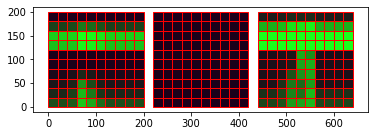

In [77]:
sensor.ReadData()
dataset.addRow(sensor.pressureDistribution, 10)

In [ ]:
dataset.saveData('export_dataframe.csv')

In [ ]:
data=pd.read_csv('./export_dataframe.csv')
data.head(10)